<a href="https://colab.research.google.com/github/AiDAPT-A/2024-Q3-ai-in-architecture/blob/main/tutorials/T3_From_Geometries_to_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From Geometries to Graphs: Extracting floor plan graphs**

This tutorial is about representing the underlying spatial organization of a floor plan: the access graph. You will learn how to extract the apartment-level access graphs from the projects' files (i.e., `.csv` tables).

<center>
<img src="https://drive.google.com/uc?export=view&id=1b0IiN0s3rYKHVFLa76d4byGum6IsYvcl" alt="AI-and-floorplans" class="center" width="1200px">
</center>

The figure above shows a random set of apartments, including their graphs, which are derived from the *Modified Swiss Dwellings* dataset (MSD) – a dataset that we developed with our lab over the last couple of year.
Interested to know more?
Please have a look at our [paper on MSD](https://arxiv.org/abs/2407.10121) and [MSD on Kaggle](https://www.kaggle.com/datasets/caspervanengelenburg/modified-swiss-dwellings).

### **Motivation**

In one of our recent (not yet officially published) writings, we found that ***the visual part in contemporary AI systems***, such as *ChatGPT* and *Midjourney*, ***lacks a certain depth in terms of ‘architectural’ competence***. In simple language: These AI systems are to a large extent incapable of reading, understanding, and/or generating architectural drawings in a meaningful manner. Have a look at the images below. Instead of ‘working’ on the underlying structure, both systems – *Google Lens* and *ChatGPT 4* – operate at the level of appearance primarily. In the case of *Google Lens*, retrievals are based on the ‘looks’. In the case of *ChatGPT*, the generations might seem reasonable (at first glance the generated images look like floor plans); however, when observed more closely, the organization in both floor plans do not make sense. When asking such systems even more banal compositional questions, it often fails to capture that composition in the generated image (top right).

<center>
<img src="https://drive.google.com/uc?export=view&id=1_EO_bSwMjwS7v1H65BgYCn-seR4onioy" alt="AI-and-floorplans" class="center" width="1200px">
</center>

One of the overall questions that we as a group and lab ask ourselves: ***How can we teach these AI systems to think more like architects?*** There is, obviously, not one answer to this question; there are multiple facets. A more bottom-up approach might help here.

Let’s start with the logic of floor plans. As likely the most important property, floor plans convey the organization of a building’s floor. In most floor plans, there is a clear underlying spatial structure. The spatial language of floor plans could be thought of as follows. A floor plan is an agglomeration of spaces and rooms; like stones are to a wall, paragraphs to a text, and wagons to a train. And there are relationships between the spaces, such as adjacency or access between them. For a large part, the composition of the spaces and their relations determine the quality of a building; whether the necessary requirements are met, whether the building can function in a particular way, whether the building fits and makes optimal use of the surrounding context, etc. This is part of an architect’s knowledge.

Teaching machines that can think alongside architects means that, first and foremost, the fundamentals need to be ingrained in the computing models. Clearly, the AI systems mentioned earlier do not have that property (at least largely not).

A key first insight is that ***the underlying structure of a floor plan is not explicitly represented in the floor plan’s corresponding image*** (which is a grid of pixels) – a data modality that most of the mentioned AI systems are trained on. We believe that other data formats are needed to make this stuff (the spaces, and their relations) explicit.

Luckily, in the case of a floor plan, as is the case with language, there is a consistent underlying spatial structure: it is composed of a finite set of spaces that have, in most cases, clear spatial relationships. ***That there is clarity as well as consistency in the way that most floor plans could be read in terms of their structure means that we can directly provide the machine the floor plan’s structure***, rather than letting the machine figure it out itself from the raw pixel values. In this way, we help the machine to understand the language of floor plans.

One of the most powerful and efficient data formats to make the spatial relationships explicit is the ***graph***. (See the graphs visualized on top of the floor plans in the first cell of this notebook.) In the context of floor plans, you’ll learn what graphs are and how to extract and represent them in code. These graphs are, as a matter of facts, the starting point (read: the ‘raw’ data) for T7.



### **Learning objectives**

- Define a graph.
- Create, manipulate, and visualize a graph in Python.
- Describe the access graph of a floor plan.
- Extract (apartment-level) access graphs from the IFC building elements.

## **(1) Graphs of floor plans**

### **The organization of a floor plan made explicit: The access graph**

As said before, "Luckily, in the case of ***a floor plan***, as is the case with language, ***\[has\] a consistent underlying spatial structure***: it is composed of a finite set of spaces that have, in most cases, clear spatial relationships." (See Motivation).

An ***access graph*** is a way of representing the underlying structure by making explicit the circulation and connectivity between rooms in a building by using a network of nodes and edges.
In this graph, each ***node represents a room***, and ***each edge shows how you can move from one room to another***, highlighting accessibility and adjacency.
It’s similar to a functional diagram or bubble diagram architects use during the design process, where circles (or bubbles) represent spaces, and lines between them show connections or flows.
However, an access graph is more precise and can include details like whether rooms are connected by a direct passage, a door, or just adjacent with no access.
This helps in analyzing and optimizing spatial layouts, circulation paths, and functional relationships.
Additionally, a ***graph can as well serve as a container for more information***, such as room shapes, semantics (e.g., function of a room).

The figure below gives a visual clarification:

<center>
<img src="https://drive.google.com/uc?export=view&id=1nDTochAjuAdx8fF6k55NyYuwfYOnAN2H" alt="AI-and-floorplans" class="center" width="1200px">
</center>

### **Self-curated Python library**

Before we start, we will 'install' ***our own library*** with some functions that we will use throughout this tutorial.
These include plotting functions for shapes and graphs, and a function to extract an access graph from a given set of IFC building elements.
There is ***no need to understand what happens inside*** these functions (although, if you are curious, please have a look!).
Instead, ***you'll need to understand how to use them***.
This will become clear when we need them!

The following code block loads the library of functions that can be found here: https://github.com/AiDAPT-A/2024-Q3-ai-in-architecture/blob/main/tutorials/t3_functions.py.
There is not need to understand these lines of code.
We have called the library `utils` (short for utilities).
Loading the function `draw_polygon` from this library is done by `from utils import draw_polygon`.
We'll come back to this later again.

In [ ]:
import requests

def url2libary(url):

    # Get url
    r = requests.get(url)

    # Make sure your filename is the same as how you want to import
    with open('utils.py', 'w') as f:
        f.write(r.text)

# If you are using GitHub, make sure you get the "Raw" version of the code
# Our library can be found here: https://github.com/AiDAPT-A/2024-Q3-ai-in-architecture/blob/main/tutorials/t3_functions.py
url = r'https://raw.githubusercontent.com/AiDAPT-A/2024-Q3-ai-in-architecture/refs/heads/main/tutorials/t3_functions.py'

# Create a library from the raw file
url2libary(url)

## **(2) Graph extraction**

In this course, we are interested in the diversity and distribution of the apartment-level floor plans comprised in the projects.

To extract the corresponding apartment graphs, we first need to find out which IFC building elements belong to which apartment.

Unluckily and not so surprising, this is not straightforward.
As a matter of facts, this might be quite different for each project, because the naming conventions are different.

In this notebook, we will consider the 6th floor of Strijp S (a.k.a. Match Box).



### **Back to the dataframe**

So let's get back where we left last week (T2): the dataframe!

Before doing so, we need to mount our *Google Drive* again:

In [ ]:
import os
from google.colab import drive

# Mounts drive (> See T2)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now, we can load the dataframe of the 6th floor:

In [ ]:
import pandas as pd

# Load 6-th floor of Strijp S (Match Box) "06 zesde verdieping.csv" as dataframe (> See T2)
path = "/content/drive/MyDrive/academia/8 data/KAAN_datasets/STRIJP/06 zesde verdieping.csv"  # Path to csv file
df_strijp = pd.read_csv(path)  # Load csv as Pandas dataframe

In today's case, we are only interested in the rows that contain IfcSpace-typed or IfcDoor-typed elements.
We create two dataframes: `df_spaces` to store the spaces, and `df_doors` to store the doors.

In [ ]:
# Load spaces and doors in separate dataframes (> See T2 for column-based sampling)
df_spaces = df_strijp[df_strijp["type"] == "IfcSpace"]
df_doors = df_strijp[df_strijp["type"] == "IfcDoor"]

# Show first 10 spaces (> See T2 for outputting the top or bottom part of a dataframe)
df_spaces.head(5)

,type,name,geometry
806,IfcSpace,74,"MULTIPOLYGON (((20.28 24.11, 20.28 25.16, 20.9..."
807,IfcSpace,75,"MULTIPOLYGON (((22.5 26.07, 23.7 26.07, 23.7 2..."
808,IfcSpace,76,"MULTIPOLYGON (((30.085 26.32, 31.26 26.32, 31...."
809,IfcSpace,72,"MULTIPOLYGON (((20.68 31.49, 31.52 31.49, 31.5..."
810,IfcSpace,73,"MULTIPOLYGON (((42.69 26.28, 36.665 26.28, 36...."


### **Apartment-level layouts**

To find out which IFC building elements belong to the same apartment, we need to investigate the names of the `df_spaces`:

In [ ]:
# Extract unique 'room' names. (> See T2)
# ('room' because the IfcSpace type elements are not necessary rooms)
names = df_spaces["name"].unique()
print(names)

['74' '75' '76' '72' '73' '70' '71' '67' '68' '69' '65' '66' '201'
 '06.E07.01' '06.E05.04' '06.E05.03' '06.E05.02' '06.E05.01' '06.E04.01'
 '06.E01.01' '06.D07.03' '06.D07.02' '06.D07.01' '06.D06.05' '06.D06.04'
 '06.D06.03' '06.D06.02' '06.D06.01' '06.D05.03' '06.D04.01' '06.D03.03'
 '06.D01.03' '06.D01.02' '06.D01.01' '06.C07.01' '06.C06.06' '06.C06.05'
 '06.C06.04' '06.C06.03' '06.C06.02' '06.C06.01' '06.C05.02' '06.C05.01'
 '06.C04.01' '06.C03.02' '06.C03.01' '06.C02.41' '06.C02.40' '06.C02.39'
 '06.C02.38' '06.C02.37' '06.C02.36' '06.C02.18' '06.C02.17' '06.C02.16'
 '06.C02.15' '06.C02.14' '06.C02.12' '06.C02.11' '06.C02.10' '06.C02.06'
 '06.C02.05' '06.C02.04' '06.C02.03' '06.C02.02' '06.C02.01' '06.C01.01'
 '06.B07.02' '06.B07.01' '06.B06.04' '06.B06.02' '06.B06.01' '06.B05.01'
 '06.B03.01' '06.B02.04' '06.B02.02' '06.B02.01' '06.B01.02' '06.B01.01'
 '06.A07.01' '06.A01.01']


Even though we could guess the naming convention, we can never be completely certain.
We could speculate a bit of course.
For instance, do the letters correspond with an apartment unit? Are all spaces that contain "A" part of the same apartment?
And why are some of the names a single number (e.g., "74") and some composed of three elements separated by a dot (e.g., "06.E07.01")?

In other words: ***We need evidence***.
And the best way is to check the associated geometries by plotting them.

In [ ]:
from shapely import wkt
import geopandas as gpd

# Import function from our own library
from utils import make_gdf_valid

# Convert Pandas dataframe into a GeoPandas dataframe (> See T2 for details)
gs_spaces = gpd.GeoSeries.from_wkt(df_spaces["geometry"])
gdf_spaces = gpd.GeoDataFrame(df_spaces, geometry=gs_spaces, crs="EPSG:28992")

# Also for the doors
gs_doors = gpd.GeoSeries.from_wkt(df_doors["geometry"])
gdf_doors = gpd.GeoDataFrame(df_doors, geometry=gs_doors, crs="EPSG:28992")

# Some polygons are not 'valid'. The following code makes them valid (no need to understand!)
make_gdf_valid(gdf_spaces)
make_gdf_valid(gdf_doors)

,type,name,geometry
120,IfcDoor,K_32_DO_WB_Single:DO.xxxx_1040x2160mm:5054126,"POLYGON ((30.13 26.28, 31.08 26.32, 31.125 26...."
148,IfcDoor,K_32_DO_WB_Single:DO.xxxx_1040x2160mm:4946126,"MULTIPOLYGON (((38.225 10.235, 38.225 11.185, ..."
150,IfcDoor,K_32_DO_WB_Single:DO.xxxx_1040x2160mm:4946117,"POLYGON ((37.155 12.82, 38.105 12.86, 38.15 12..."
161,IfcDoor,K_32_DO_WB_Single:DO.xxxx_1040x2160mm:4945851,"POLYGON ((13.975 10.235, 13.935 11.185, 13.935..."
163,IfcDoor,K_32_DO_WB_Single:DO.xxxx_1040x2160mm:4945842,"MULTIPOLYGON (((15.045 12.82, 15.09 12.86, 15...."
...,...,...,...
718,IfcDoor,K_32_DO_WB_Single door:DO.xxxx_1250x2300mm:167...,"MULTIPOLYGON (((9.442 16.46, 9.415 17.54, 9.41..."
720,IfcDoor,K_32_DO_WB_Single door:DO.xxxx_1250x2300mm:167...,"MULTIPOLYGON (((9.442 23.46, 9.415 24.54, 9.41..."
722,IfcDoor,K_32_DO_WB_Single door:DO.xxxx_1250x2300mm:167...,"MULTIPOLYGON (((9.442 22.06, 9.415 23.14, 9.41..."
724,IfcDoor,K_32_DO_WB_Single door:DO.xxxx_1250x2300mm:167...,"MULTIPOLYGON (((9.442 29.06, 9.415 30.14, 9.41..."


Let's have a look at the ***spaces that contain the letter "A"*** (dumped in a new dataframe called `gdf_spaces_A`) and ***spaces that contain a single number only*** (dumped in a new dataframe called `gdf_spaces_num`).

In [ ]:
gdf_spaces_A = gdf_spaces[gdf_spaces["name"].str.contains("A")]  # Checks whether name contains "A"
gdf_spaces_num = gdf_spaces[gdf_spaces["name"].str.len() < 4]  # Checks whether the length of the name is less than 4

Now let's plot all spaces that contain "A", by plotting `gdf_spaces_A`:



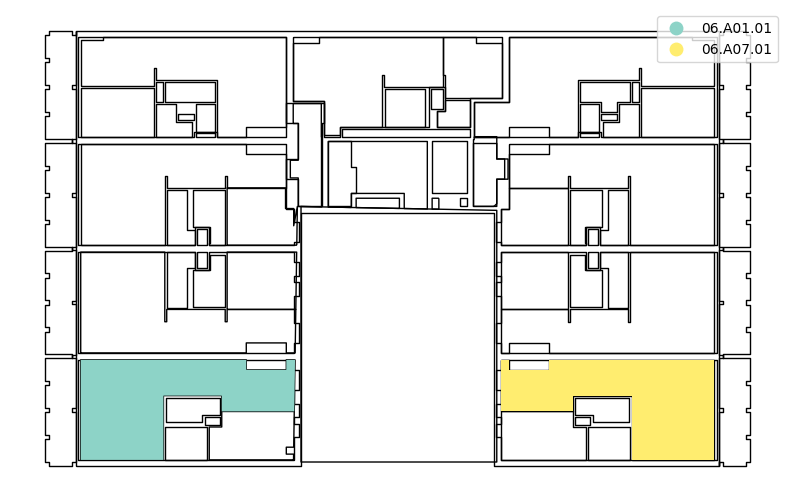

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure (> See T1 for details)
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plotting the rooms that contain an "A" in the name
# Here, we provide the axis onto which to plot as well (keyword is "ax")
_ = gdf_spaces.plot(ax=ax, column="name", edgecolor="black", facecolor="none")
_ = gdf_spaces_A.plot(ax=ax, column="name", legend=True, cmap="Set3")

Clearly, these ***two rooms are not located in the same apartment!*** On the other hand, we might have discovered that everything with a letter is actually a room!

In [ ]:
# Create geopandas dataframe to store the rooms
gdf_rooms = gdf_spaces[gdf_spaces["name"].str.len() > 5]  # Same as filtering on a letter. Why?

Let's see if we are right:

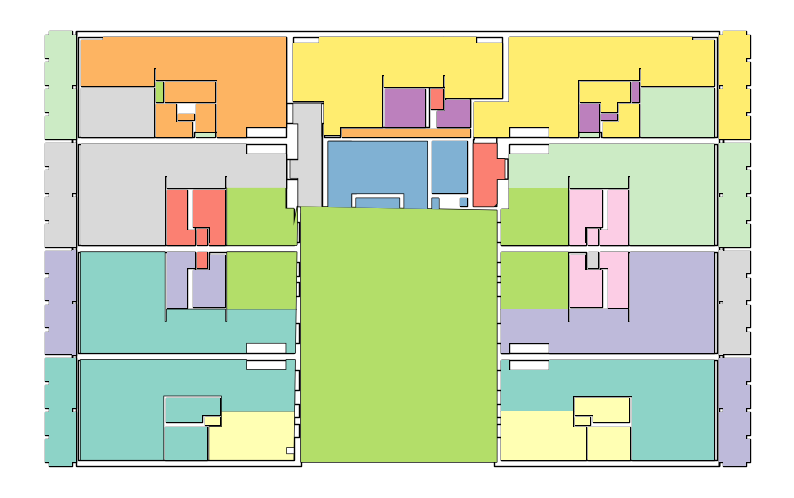

In [ ]:
# Set up the figure (> See T1 for details)
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plotting the rooms that contain an "A" in the name
# Here, we provide the axis onto which to plot as well (keyword is "ax")
_ = gdf_spaces.plot(ax=ax, column="name", edgecolor="black", facecolor="none")
_ = gdf_rooms.plot(ax=ax, column="name", legend=False, cmap="Set3")

Indeed, we are right.

Now let's have a look at the spaces in `gdf_spaces_num`:

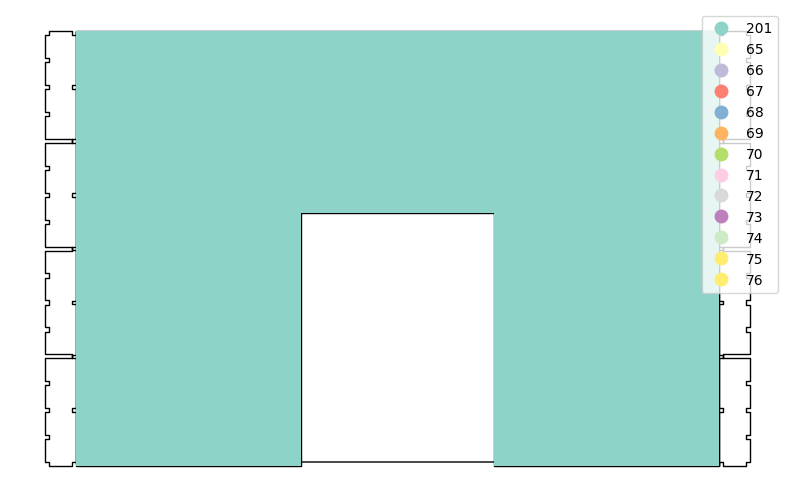

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plotting the rooms thar are solely a number
# Here, we provide the axis onto which to plot as well (keyword is "ax")
_ = gdf_spaces.plot(ax=ax, column="name", edgecolor="black", facecolor="none")
_ = gdf_spaces_num.plot(ax=ax, column="name", legend=True, cmap="Set3")

Let's get rid of the one with number 201, by simply allowing only strings of length 2 (or less), which means: only numbers between 0 and 99 are sampled.
To be precise: between -99 and 99.

In [ ]:
gdf_units = gdf_spaces[gdf_spaces["name"].str.len() < 3]  # Checks whether the length of the name is less than 3
# Note here that we overwrite the previously defined 'gdf_units' !

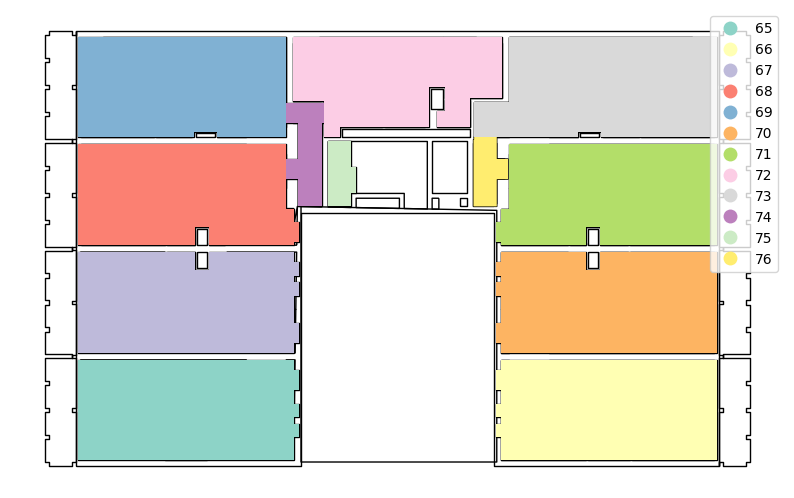

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plotting the rooms that contain a single number between -99 and 99
# Here, we provide the axis onto which to plot as well (keyword is "ax")
_ = gdf_spaces.plot(ax=ax, column="name", edgecolor="black", facecolor="none")
_ = gdf_units.plot(ax=ax, column="name", legend=True, cmap="Set3")

That looks more like it.
Indeed: the IfcSpace type elements with numbers smaller than 100 are indeed (sort of) representing the apartment units.
Some of the spaces ("74", "75", and "76") are not apartments, but rather lay outside the apartments and are likely (semi-)public.

We have enough ingredients to define an algorithm that extracts the individual units.
Many algorithms of course exist, and the idea for your projects is that you find the most suitable in your case (read: one that works).

In the case of Strijp S, we set it up as follows:
- **(A)** Create an empty dictionary called `dict_floor`.
- **(B)** Using a `for` loop, iterate through the rows in `gdf_units`. The rows will include the ones that are not units, such as "74" (see figure above). Why don't we leave them out? We don't have a proper way yet to exclude them yet! Or can you think of one?
- **(C)** For each item (which is a unit), create an empty lists to store 1) the room geometries, 2) the corresponding names, and 3) the door geometries.
-**(D)** For each item check the overlap between the rooms (in `gdf_rooms`) and the doors (in `gdf_doors`).
-**(E)** If there is a reasonable overlap between the shape of the unit and the shape of the room or door (more than, say, 0.3 $m^2$) append it to the lists accordingly
-**(F)** In the case of a room, append the room's name (e.g., "06.E07.01") to the list of names and the Polygonal shape of the room to the list of shapes.
-**(G)** When the loop for a unit is finished, create a dictionary with keys called "room geometries", "room names", and "door geometries" with the corresponding lists as values.
-**(H)** This dictionary will serve as value for the larger dictionary to store the whole floor (`dict_floor`): key = unit's name (e.g., "65") and value: the unit's dictionary.
-**(I)** Don't add a key-value pair for which the number of rooms is less than 3 (i.e., `len(polygons_room) < 3`).
This will get rid of the elements in `gdf_units` that are *not* units, such as "74".

The following code block will do exactly the above.
It is quite long.
To make it less daunting, ***try to go through it line by line***.

In [ ]:
# Set empty dictionary for a floor plan
dict_floor = {}  # (A) above

# Loop through units
# Looping through GeoPandas dataframes can be down by gdf.iterrows()
for elem_unit in gdf_units.itertuples():  # (B) above

    # Extract geometry (polygon) and name of the UNIT
    poly_unit = elem_unit.geometry
    name_unit = elem_unit.name

    # 1) Aggregate rooms and names
    polygons_room = []  # (C) above
    names_room = []  # (C) above
    for elem_room in gdf_rooms.itertuples():

        # Extract geometry (polygon) and name of the ROOM
        poly_room = elem_room.geometry
        name_room = elem_room.name

        # Don't consider spaces smaller than 1 m2
        if poly_room.area < 1: continue  # Continue means: go directly to next iteration

        # Compute intersection
        intersection = poly_unit.intersection(poly_room)  # (D) above
        if intersection.area > 0.3:  # (E) above
            polygons_room.append(poly_room)   # (F) above
            names_room.append(name_room)  # (F) above

    # 2) Aggregate doors. Nearly equivalent to 1).
    polygons_door = []  # (C) above
    for elem_door in gdf_doors.itertuples():

        # Extract geometry (polygon) of the DOOR
        poly_door = elem_door.geometry

        # Check intersection
        if poly_unit.intersects(poly_door):  # (E) above
            polygons_door.append(poly_door)  # (F) above

    # Check number of rooms in unit
    # And: consider units with more than 2 rooms only
    if len(polygons_room) > 2:  # (I)

        # 3) Add to dictionary
        dict_floor[name_unit] = {"room geometries": polygons_room,  # (G and H)
                                            "room names": names_room,
                                            "door geometries": polygons_door}

Now, let's have a look at our dictionary.
There exists a nice library for printing slightly nicer: `pprint`, which short for ***pretty*** print.

In [ ]:
from pprint import pprint  # Package to print a bit nicer!

# Only print apartment called "65"
pprint(dict_floor['65'])

{'door geometries': [<POLYGON ((13.975 10.235, 13.935 11.185, 13.935 11.23, 14.025 11.23, 14.025 ...>,
                     <MULTIPOLYGON (((15.045 12.82, 15.09 12.86, 15.09 12.77, 15.03 12.77, 15.03 ...>,
                     <MULTIPOLYGON (((21.005 13.195, 21.005 14.155, 21.045 14.155, 21.045 13.195,...>,
                     <MULTIPOLYGON (((18.38 14.2, 18.34 14.2, 18.34 14.29, 18.4 14.29, 18.4 14.27...>,
                     <POLYGON ((19.455 14.24, 20.175 14.24, 20.175 14.27, 20.16 14.27, 20.16 14.2...>,
                     <MULTIPOLYGON (((9.442 10.86, 9.415 11.94, 9.415 12.005, 9.423 12.005, 9.423...>,
                     <MULTIPOLYGON (((9.442 12.26, 9.415 13.34, 9.415 13.405, 9.423 13.405, 9.423...>],
 'room geometries': [<MULTIPOLYGON (((20.696 9.52, 16.315 9.52, 16.315 11.23, 16.965 11.23, 16.96...>,
                     <POLYGON ((16.215 9.52, 14.035 9.52, 14.035 11.23, 16.018 11.23, 16.215 11.2...>,
                     <MULTIPOLYGON (((15.09 12.76, 15.09 12.745, 16.85 1

That is looking good! Let's plot them.
To do this, we will use slightly different plotting functions.
We will use the once from our own repository.
The function is called `draw_polygon()`.

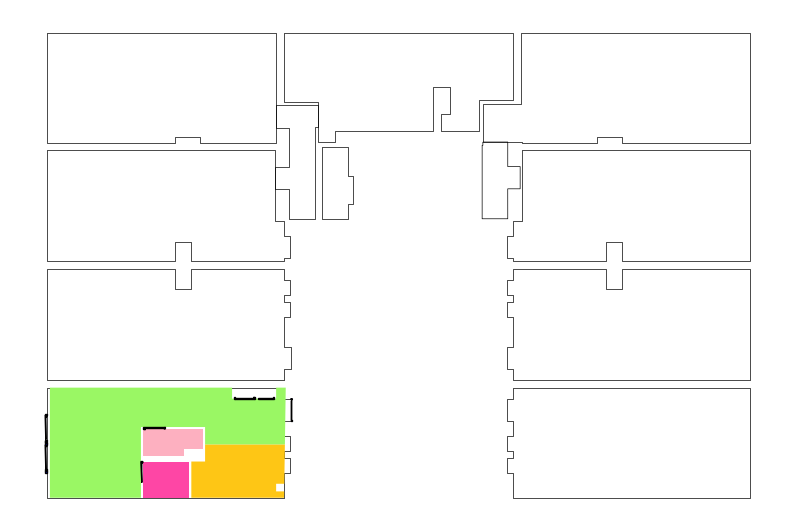

In [ ]:
# Import function to draw a polygonal shape from our library
from utils import draw_shape, generate_color

# Get dictionary of unit "65" (> See T1 for slicing a dictionary based on the key)
dict_unit_65 = dict_floor['65']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Plot all units
_ = gdf_units.plot(ax=ax, column="name", edgecolor="black", facecolor="none", linewidth=0.5)

# Plot the rooms in the unit -> Loop over the key ''room geometries"
for poly in dict_unit_65['room geometries']:
    color = generate_color() # Color each shape differently!
    draw_shape(ax, poly, facecolor=color, edgecolor="none")

# Plot the doors in the unit -> Loop over the key "door geometries"
for poly in dict_unit_65['door geometries']:
    draw_shape(ax, poly, facecolor='blue', edgecolor="black")

Perfect!
That looks very good.

Now, we are ready to extract the apartment-level graphs.

### **Graph extraction algorithm**

In this part of the notebook, we extract the access graphs from the apartment dictionaries.
We will use the graph extraction algorithm from our own library (`extract_access_graph`).
The algorithm converts a list of IFC building elements into an access graph where nodes represent rooms and edges represent connections between them.
The ***algorithm loops through all combinations of room pairs and identifies their connections*** in three ways:
direct ***passage*** (if rooms are extremely close and do not have a wall in between them), through a ***door*** (if a door intersects both rooms), and ***adjacency*** (if rooms share a wall but have no door).
Each connection is labeled as either accessible (`"connectivity"` = 1) or not accessible (`"connectivity"` = 0).

Are you curious how this is set up specifically? Have a look at the `utils.py` file which you can find under the `Files` tab in the navigation pane on the left. Double click on the file and it will appear on the right side of the notebook.

In [ ]:
# Import function to extract a graph from our library
from utils import extract_access_graph

# Create empty list to store the graphs
list_graphs = []

# Loop through items in the dictionary
# They come in key-value pairs
for unit_name, unit_dict in dict_floor.items():

    # Extract relevant information from the unit's dictionary
    polygons_room = unit_dict['room geometries']
    names_room = unit_dict['room names']
    polygons_door = unit_dict['door geometries']

    # Extract access graph
    G = extract_access_graph(polygons_room, polygons_door, names_room, unit_name)

    # Append the graph to the list
    list_graphs.append(G)

In [ ]:
print(f"Number of apartment graphs in 6-th floor: {len(list_graphs)}\n")
for G in list_graphs:
    print(f"Unit {G.graph['apartment name']}: {G}")

Number of apartment graphs in 6-th floor: 9

Unit 72: Graph with 4 nodes and 3 edges
Unit 73: Graph with 5 nodes and 7 edges
Unit 70: Graph with 4 nodes and 5 edges
Unit 71: Graph with 4 nodes and 5 edges
Unit 67: Graph with 4 nodes and 5 edges
Unit 68: Graph with 4 nodes and 5 edges
Unit 69: Graph with 5 nodes and 7 edges
Unit 65: Graph with 4 nodes and 6 edges
Unit 66: Graph with 4 nodes and 6 edges


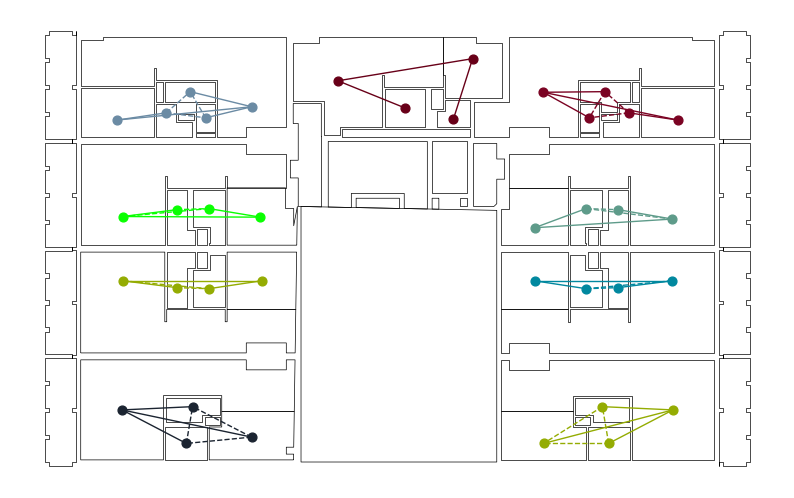

In [ ]:
# Import function to draw a graph from our library
from utils import draw_graph

# Set up the figure
fs = 10
fig, ax = plt.subplots(figsize=(fs, fs))
ax.axis('off')

# Plot all units
_ = gdf_rooms.plot(ax=ax, column="name", edgecolor="black", facecolor="none", linewidth=0.5)

for G in list_graphs:
    color = generate_color()  # Color each graph differently!
    draw_graph(G, ax, node_color=color, edge_color=color, node_size=fs*4, edge_width=fs/10)

Great, the graphs are properly extracted and visualized!

You can store the graphs in a folder as follows:

In [ ]:
# Create a directory to store the graphs in
path_graphs = r"/content/drive/MyDrive/academia/8 data/KAAN_datasets/STRIJP/Apartment Graphs"
os.makedirs(path_graphs, exist_ok=True)

In [ ]:
from utils import save_pickle

name_save = "/content/drive/MyDrive/academia/8 data/KAAN_datasets/STRIJP/Apartment Graphs/6th floor.pickle"
save_pickle(list_graphs, name_save)

## **(3) Assignment**

Develop your own code to convert the data frames of your projects into an apartment-level graph dataset.
It should be done for each floor of your project, if that floor contains residential apartments.

In the case of Strijp S: make sure that the balconies are also included in the apartment graphs.
To do this, you must modify the code block that gather the IFC building elements per apartment.

In the case of the other projects, please be aware that they (likely) have other conventions for naming the IFC building elements!

- **Apartment extraction** (5 pt)
    - Code block that loads dataframe of a building's floor and converts it into a valid dataframe of spaces and doors. (1 pt)
    - Code block that creates a dictionary of the floor that contains dictionaries of the units, including their IFC building elements. These should be three lists: one for room geometries, one for room names, one for door geometries. (2 pt)
    - Provide plots to show that the correct elements are sampled. (2 pt)
- **Graph extraction** (5 pt)
    - Code block that extracts the access graphs for all units within the larger (floor) dictionary. Should be a list of graphs. (2 pt)
    - Visualize all graphs on top of the floor. (You may choose which floor.) (2 pt)
    - Append all graphs (across all floors) in one list. (1 pt)
- **Save** (1 pt)
    - Save the list of graphs in a dedicated folder in your *Google Drive*. (1 pt)